In [1]:

%pprint
%matplotlib inline
import sys
import os.path as osp

executable_path = sys.executable; scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts')
py_folder = osp.abspath(osp.join('..', 'py')); ffmpeg_folder = r'C:\ffmpeg\bin'
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, wsu, speech_engine)
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
import matplotlib.dates as mdates

Pretty printing has been turned OFF
======== Neo4j/5.24.2 ========
Utility libraries created in 7 seconds


In [28]:

# Cypher for days between application and rejection emails grouped by response time since last day of work
last_day_of_work = datetime(2024, 6, 13)
comment_str = 'last day of work'
formatted_date = last_day_of_work.strftime("%Y-%m-%d")
cypher_str = f'''
    // Calculate days between application and rejection emails and group by response time
    MATCH (fn:FileNames)
    WHERE
        fn.opportunity_application_email_date IS NOT NULL
        AND fn.rejection_email_date IS NOT NULL
        AND fn.rejection_email_date >= date("{formatted_date}")
    WITH
        duration.between(
            date(fn.opportunity_application_email_date),
            date(fn.rejection_email_date)
        ).days AS days_to_rejection
    RETURN
        days_to_rejection,
        COUNT(*) as rejection_count
    ORDER BY days_to_rejection;'''

In [29]:

row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
assert row_objs_list, "You are not getting any rejection days counts"
rejections_df = DataFrame(row_objs_list).set_index('days_to_rejection')
rejections_df.sample(5)

,rejection_count
days_to_rejection,
3,13
21,1
20,2
16,2
8,5


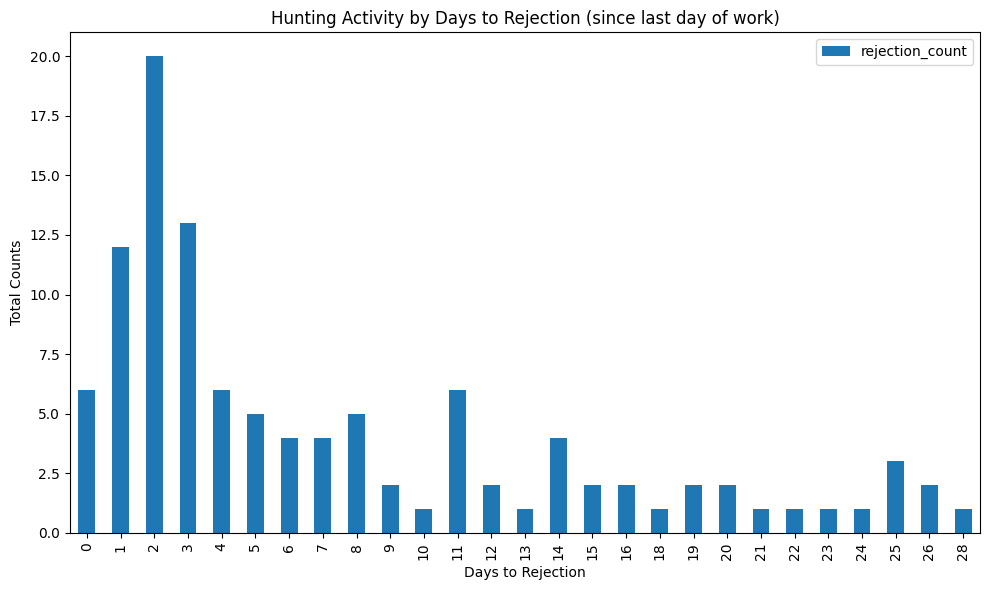

In [32]:

# Plotting the stacked bar chart
ax = rejections_df.plot(kind='bar', figsize=(10, 6))

# Add labels and title
ax.set_xlabel('Days to Rejection')
ax.set_ylabel('Total Counts')
ax.set_title(f'Hunting Activity by Days to Rejection (since {comment_str})')

# Display the plot
plt.tight_layout()
plt.show()

In [21]:

window = 30
min_periods = 7
rolling_mean = lambda srs: srs.rolling(window=window, min_periods=min_periods).mean()
cumulative_sum = lambda srs: srs.cumsum()
rejections_color = 'red'
def plot_total_data(ax, func, label_prefix=''):
    ax.plot(
        rejections_df.index,
        func(rejections_df['days_to_rejection']),
        label=f'{label_prefix}Rejections', color=rejections_color
    )

In [22]:

def format_plot(fig, ax):
    
    # Customize the plot
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Format x-axis ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
    
    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    # Adjust layout to prevent cutting off labels
    fig.tight_layout()

In [33]:

# Cypher for days between application and rejection emails grouped by response time
cypher_str = f'''
    // Calculate days between application and rejection emails
    MATCH (fn:FileNames)
    WHERE
        fn.opportunity_application_email_date IS NOT NULL
        AND fn.rejection_email_date IS NOT NULL
        AND fn.rejection_email_date >= date("{formatted_date}")
    RETURN
        fn.opportunity_application_email_date AS email_date,
        duration.between(
            date(fn.opportunity_application_email_date),
            date(fn.rejection_email_date)
        ).days AS days_to_rejection
    ORDER BY days_to_rejection;'''

In [34]:

row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
assert row_objs_list, "You are not getting any rejection days counts"
rejections_df = DataFrame(row_objs_list).groupby('email_date').mean()

# Convert neo4j.time.Date to Python date and convert to datetime
rejections_df.index = [date(d.year, d.month, d.day) for d in rejections_df.index]
rejections_df.index = pd.to_datetime(rejections_df.index)

rejections_df.sample(5)

,days_to_rejection
2024-09-08,6.333333
2024-06-30,13.500000
2024-10-14,3.000000
2024-06-20,2.000000
2024-06-26,20.000000


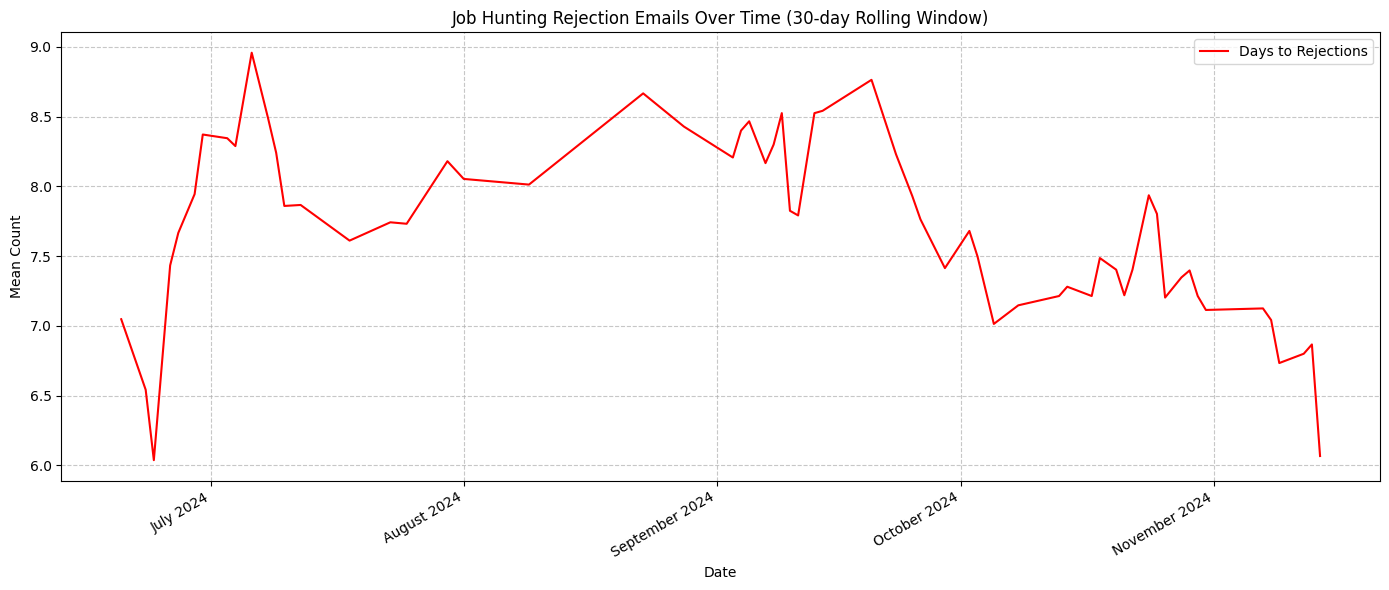

In [35]:

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the rolling data
plot_total_data(ax, rolling_mean, label_prefix='Days to ')

# Customize the plot
ax.set_title(f'Job Hunting Rejection Emails Over Time ({window}-day Rolling Window)')
ax.set_ylabel('Mean Count')
format_plot(fig, ax)

# Show the plot
plt.show()